In [1]:
#|default_exp autometric
# Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *
# Configure environment

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import autometric
import torch

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

# String Geodesics
> No Flows, no ODEs, no distributions: just a string in the wind.

# Implementation

In [2]:
#|export
from torch.autograd import grad
def compute_jacobian_function(f, x, create_graph=False, retain_graph=True):
    """
    Compute the Jacobian of the decoder wrt a batch of points in the latent space using an efficient broadcasting approach.
    :param model: The VAE model.
    :param z_batch: A batch of points in the latent space (tensor).
    :return: A batch of Jacobian matrices.
    """
    # z_batch = z_batch.clone().detach().requires_grad_(True)
    x = x.clone()
    x.requires_grad_(True)
    # model.no_grad()
    output = torch.vmap(f)(x)
    batch_size, output_dim, latent_dim = *output.shape, x.shape[-1]

    # Use autograd's grad function to get gradients for each output dimension
    jacobian = torch.zeros(batch_size, output_dim, latent_dim).to(x.device)
    for i in range(output_dim):
        grad_outputs = torch.zeros(batch_size, output_dim).to(x.device)
        grad_outputs[:, i] = 1.0
        gradients = grad(outputs=output, inputs=x, grad_outputs=grad_outputs, create_graph=create_graph, retain_graph=retain_graph, only_inputs=True)[0]
        jacobian[:, i, :] = gradients
    return jacobian

def pullback_metric(fcn, x, create_graph=False, retain_graph=True):
    jac = compute_jacobian_function(fcn, x, create_graph, retain_graph)
    metric = torch.einsum('Nki,Nkj->Nij', jac, jac)
    return metric

In [3]:
#|export
import torch
from torch import nn
import lightning as pl

class StringGeodesic(pl.LightningModule):
    def __init__(self, 
                 immersion, # a metric object.
                 start, # starting point
                 end, # ending point
                 dim: int = 2, # dimension of the space in which the metric lives.
                 num_beads: int = 1000,
                 flexibility: int = 10,
                 step_size = 0.1,
                 learning_rate = 1e-5, 
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                 ):
        super().__init__()
        
        self.dim = dim
        self.num_beads = num_beads
        self.immersion = immersion
        self.flexibility = flexibility
        self.step_size = step_size
        self.lr = learning_rate
        
        self.beads = torch.vstack(
            [torch.lerp(start, end, t) for t in torch.linspace(0,1,steps=num_beads)]
        ).float().to(device)
        self.metric_per_bead = self.get_metric(self.beads).float()
        self.distances = self.progressive_lengths(self.beads, self.metric_per_bead)

        # Create the network layers
        self.Force = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, dim),
        )
    
    def get_metric(self, base_points):
        return torch.concatenate([torch.eye(self.dim).to(base_points.device)[None, :, :] for i in range(len(base_points))], dim=0)
        # return pullback_metric(
        #     self.immersion,
        #     base_points,
        #     )
    
    def inner_product(self, vec, metric):
        return vec @ metric @ vec
        
    def progressive_lengths(self, beads, metric_per_bead):
        # Computes length between each consecutive bead
        lengths = torch.zeros(self.num_beads, device = beads.device)
        for i in range(1, len(beads)):
            lengths[i]  = lengths[i-1] + torch.sqrt(self.inner_product(beads[i] -  beads[i-1], metric_per_bead[i]))
            
        print(f"{beads.device=} {metric_per_bead.device=} {lengths.device=}")
        return lengths
    
    def apply_force(self, beads, forces, lengths):
        # applies the force given to each bead, modulating by lengths
        distances_from_end = torch.sqrt(lengths * (lengths[-1] - lengths)) 
        force_modulator = torch.sigmoid(self.flexibility*distances_from_end)*2 - 1
        print(f'{force_modulator.device=} {distances_from_end.device=} {beads.device=}')
        fm = (self.step_size*force_modulator[:,None])
        beads_after_wind = fm*forces + beads
        return beads_after_wind
        
    def step(self, batch, batch_idx):
        # calculate force assigned to each bead
        force = self.Force(self.beads)
        # apply the force to get new beads
        self.beads = self.apply_force(self.beads, force, self.distances)
        self.metric_per_bead = self.get_metric(self.beads).float()
        self.distances = self.progressive_lengths(self.beads, self.metric_per_bead)
        return self.distances[-1]
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Testing

In [4]:
from autometric.datasets import Sphere

INFO: Using pytorch backend


In [5]:
sphere = Sphere()
def sphere_map(x):
    if x.dim() == 1:
        return sphere.immersion(x)
    elif x.dim() == 2:
        return torch.vmap(sphere.immersion)(x)
    elif x.dim() == 3:
        return torch.vmap(torch.vmap(sphere.immersion))(x)
    else:
        raise NotImplementedError("Too many dimensions!")

In [6]:
start = torch.tensor([0.1, 0.9])
end = torch.tensor([0.9, 0.1])

In [7]:

SG = StringGeodesic(
    sphere_map,
    start = start,
    end = end,
    dim = 2,
    step_size = 1
)

beads.device=device(type='cuda', index=0) metric_per_bead.device=device(type='cuda', index=0) lengths.device=device(type='cuda', index=0)


In [8]:
sphere.immersion(torch.rand(40,2))

tensor([[ 0.9426,  0.2370,  0.2353],
        [ 0.7344,  0.2550, -0.6290]])

In [9]:
import geomstats.backend as gs

In [10]:
from lightning import Trainer

In [11]:
from autometric.datasets import dataloader_from_pointcloud_with_distances
trainloader = dataloader_from_pointcloud_with_distances(torch.zeros(100,3), torch.zeros(100,100), 1) 

/home/piriac/Pumberton/Workshop/23-Geometric-AE/autometric/src/autometric/datasets.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pointcloud = torch.tensor(pointcloud, dtype=torch.float32)
/home/piriac/Pumberton/Workshop/23-Geometric-AE/autometric/src/autometric/datasets.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.distances = torch.tensor(distances, dtype=torch.float32)


In [12]:
trainer = Trainer(
    max_epochs=100, 
    accelerator='cuda',
    use_distributed_sampler=False,
    enable_progress_bar=True, enable_model_summary=False,
    )
SG = SG.to(device)
trainer.fit(
    model=SG,
    train_dataloaders=trainloader,        
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/piriac/Pumberton/Workshop/23-Geometric-AE/autometric/.pixi/envs/default/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/

Training: |          | 0/? [00:00<?, ?it/s]

force_modulator.device=device(type='cuda', index=0) distances_from_end.device=device(type='cuda', index=0) beads.device=device(type='cuda', index=0)
beads.device=device(type='cuda', index=0) metric_per_bead.device=device(type='cuda', index=0) lengths.device=device(type='cuda', index=0)
force_modulator.device=device(type='cuda', index=0) distances_from_end.device=device(type='cuda', index=0) beads.device=device(type='cuda', index=0)
beads.device=device(type='cuda', index=0) metric_per_bead.device=device(type='cuda', index=0) lengths.device=device(type='cuda', index=0)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
SG.metric.metric_matrix(SG.beads).float().device

device(type='cuda', index=0)

In [ ]:
SG.metric.inner_product(SG.beads[1] - SG.beads[0], SG.beads[1] - SG.beads[0], SG.metric.metric_matrix(SG.beads).float()[0])

tensor([2.5780e-05, 2.5317e-05], device='cuda:0')

In [ ]:
beads_per_time = []
for t in trange(100):
    d = SG.forward()
    beads_per_time.append(SG.beads.detach().numpy())
beads_per_time = np.array(beads_per_time)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from autometric.utils import gif_from_multiarray


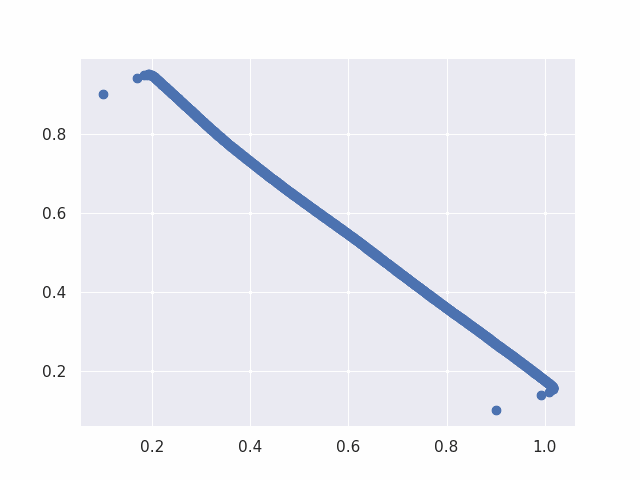

In [ ]:
gif_from_multiarray(np.array(beads_per_time))

In [ ]:
SG.Force(torch.rand(2))

tensor([ 0.0879, -0.1021], grad_fn=<ViewBackward0>)

In [ ]:
# sync changes to the library
from IPython.display import display, Javascript
import time
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
!pixi run nbsync